In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, auc, precision_score, recall_score, f1_score, confusion_matrix, accuracy_score

from tqdm import tqdm 

import os
import glob
import math
import random

In [2]:
def find_threhsold_at_FPR(df, dist_type, threshold_FPR_at, label='edited', steps=0.01):
    # Find the threshold for FPR = threshold_FPR_at
    min_dist_type = df[dist_type].min()
    max_dist_type = df[dist_type].max()
    best_threshold = max_dist_type
    best_acc = 0
    
    for threshold in np.arange(min_dist_type, max_dist_type, steps):
        y_score = df[dist_type].apply(lambda x: 1 if x >= threshold else 0)
        y_true = df[label]
        tn, fp, fn, tp = confusion_matrix(y_true, y_score).ravel()
        TPR = fp / (fp + tn)
        if TPR <= threshold_FPR_at:
            acc = (tp + tn) / (tp + tn + fp + fn)
            if acc > best_acc:
                best_acc = acc
                best_threshold = threshold 
            
    return best_threshold

def find_threhsold_best_accuracy(df, dist_type, threshold_FPR_at, label='edited', steps=0.01):
    # Find the threshold for FPR = threshold_FPR_at
    min_dist_type = df[dist_type].min()
    max_dist_type = df[dist_type].max()
    best_threshold = max_dist_type
    best_acc = 0
    
    for threshold in np.arange(min_dist_type, max_dist_type, steps):
        y_score = df[dist_type].apply(lambda x: 1 if x >= threshold else 0)
        y_true = df[label]
        tn, fp, fn, tp = confusion_matrix(y_true, y_score).ravel()
        acc = (tp + tn) / (tp + tn + fp + fn)
        if acc > best_acc:
            best_acc = acc
            best_threshold = threshold 
            
    return best_threshold

def check_AUC_ROC(df, title='', dist_type='HC', show_plot=True, threshold_FPR_at=None, steps=0.01):
    HC_edits = df[df['edited'] == 1][dist_type].values
    HC_original = df[df['edited'] == 0][dist_type].values
    
    y_test = [1 for _ in range(len(HC_edits))] + [0 for _ in range(len(HC_original))]
    y_prob = list(HC_edits) + list(HC_original)
    
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)

    # Calculate the ROC curve
    if threshold_FPR_at == None:
        # Find the index of the point on the ROC curve closest to (0, 1)
        best_threshold_index = np.argmax(tpr - fpr)
        # Get the threshold corresponding to the point on the ROC curve
        best_threshold = thresholds[best_threshold_index]
    elif threshold_FPR_at == -1:
        best_threshold = find_threhsold_best_accuracy(df, dist_type, threshold_FPR_at, label='edited', steps=steps)
    else:
        best_threshold = find_threhsold_at_FPR(df, dist_type, threshold_FPR_at, label='edited', steps=steps)
    
    # Calculate the AUC-ROC score
    auc_roc = auc(fpr, tpr)
    if show_plot:
        # Plot the ROC curve
        plt.figure(figsize=(8, 8))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {auc_roc:.2f} Threshold = {best_threshold:.2f}')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate (1 - Specificity)')
        plt.ylabel('True Positive Rate (Sensitivity)')
        plt.title(f'Receiver Operating Characteristic (ROC) Curve on {dist_type} \n{title}')
        plt.legend(loc="lower right")
        plt.show()
    
    return best_threshold, auc_roc

def get_AUC(df, dist_type='HC', label='edited'):
    HC_edits = df[df[label] == 1][dist_type].values
    HC_original = df[df[label] == 0][dist_type].values

    y_test = [1 for _ in range(len(HC_edits))] + [0 for _ in range(len(HC_original))]
    y_prob = list(HC_edits) + list(HC_original)
    
    NaN_list = []
    # Check for NaN
    for i, v in enumerate(y_prob):
        if np.isnan(v):
            NaN_list.append(i)
            
    for i in NaN_list:
        y_test.pop(i)
        y_prob.pop(i)

    # Calculate the ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    auc_roc = auc(fpr, tpr)
    return auc_roc

def calc_metrics(df, true_label, pred_label):
    TP = len(df[(df[pred_label]==1) & (df[true_label]==1)])
    FN = len(df[(df[pred_label]==0) & (df[true_label]==1)])
    FP = len(df[(df[pred_label]==1) & (df[true_label]==0)])
    TN = len(df[(df[pred_label]==0) & (df[true_label]==0)])

    TPR = TP / (TP + FN)
    FPR = FP / (FP + TN)
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    
    return TPR, FPR, accuracy

In [13]:
# Calculate min p values second dataset
topics = ['AbstractDataset', 'NewsDataset', 'WikiDataset']
numbers_sentences = [50, 100, 200]
edit_ratios = [0.1, 0.2]

for topic in topics:
    for number_senteces in numbers_sentences:
        for edit_ratio in edit_ratios:
            for fold in range(10):
                # Get data 
                folder_path = f'D:\\.Idan\\תואר שני\\תזה\\SecondDataset\\Cross_validation\\{topic}\\{number_senteces}_sentences\\{edit_ratio}\\fold_{fold}\\results\\'
                files = glob.glob(f'{folder_path}/*_results.csv')
                df = None
                for file in files:
                    if df is None:
                        df = pd.read_csv(file)
                    else:
                        df = pd.concat([df, pd.read_csv(file)])

                df = df.reset_index()
                df.drop(columns=['index'], inplace=True)

                # For each article 
                for i in tqdm(range(len(df))):
                    article_id = df.iloc[i]['Unnamed: 0'].split('_')[1]
                    article_type = df.iloc[i]['Unnamed: 0'].split('_')[3]

                    # Calc minus log min p value
                    current_article_df = pd.read_csv(f'{folder_path}article_{article_id}_sentences_{article_type}.csv')
                    minus_log_min_p_value = -math.log(current_article_df['pvalue'].min())
 
                    # Save the results
                    article_results_path = f'{folder_path}article_{article_id}_{article_type}_results.csv'
                    article_results = pd.read_csv(article_results_path)
                    article_results.loc[0, 'minus_log_min_p_value'] = minus_log_min_p_value
                    article_results.to_csv(article_results_path)

100%|███████████████████████████████████████████████████████████████████████████████| 588/588 [00:03<00:00, 150.75it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 170/170 [00:01<00:00, 126.18it/s]


In [63]:
# Calculate min p values main dataset
topics = ['characters_articles', 'locations_articles', 'nature_articles', 'video_games_series_movies_articles', 'war_articles']
edit_ratios = [0.05, 0.1, 0.15]
models_names = ['gpt2xl', 'phi2']

for topic in topics:
    for edit_ratio in edit_ratios:
        for model_name in models_names:
            for fold in range(10):
                results_folder = 'results' if model_name == 'gpt2xl' else 'results_phi2'
                folder_path = f'D:\\.Idan\\תואר שני\\תזה\\mainDataset\\generatedArticles\\Cross_validation\\{topic}\\edit_ratio_{edit_ratio}\\fold_{fold}\\{results_folder}\\'
                files = glob.glob(f'{folder_path}/*_results.csv')
                
                # Get data
                df = None
                for file in files:
                    if df is None:
                        df = pd.read_csv(file)
                    else:
                        df = pd.concat([df, pd.read_csv(file)])

                df = df.reset_index()
                df.drop(columns=['index'], inplace=True)

                # For each article 
                for i in tqdm(range(len(df))):
                    article_id = df.iloc[i]['Unnamed: 0'].split('_')[1]
                    article_type = df.iloc[i]['Unnamed: 0'].split('_')[3]

                    # Calc minus log min p value
                    current_article_df = pd.read_csv(f'{folder_path}article_{article_id}_sentences_{article_type}.csv')
                    minus_log_min_p_value = -math.log(current_article_df['pvalue'].min())

                    # Save the results
                    article_results_path = f'{folder_path}article_{article_id}_{article_type}_results.csv'
                    article_results = pd.read_csv(article_results_path)
                    article_results.loc[0, 'minus_log_min_p_value'] = minus_log_min_p_value
                    article_results.to_csv(article_results_path)

100%|█████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 150.37it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 93.14it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 59.37it/s]


In [11]:
# Calculate Best Threshold
topics = ['AbstractDataset', 'WikiDataset', 'NewsDataset']
numbers_sentences = [50, 100, 200] #  
edit_ratios = [10, 20]
models = ['GPT2XL', 'Phi2']  
threshold_FPR_at = -1 # -1 to get the optimal TPR+(1-FPR) #None to get the closest pont to (0, 1) #0.05 

results_path = 'D:\\.Idan\\תואר שני\\תזה\\SecondDataset\\ForAlon\\results_SecondDataset.csv'
df_results = pd.read_csv(results_path)

for model in models:
    suffix = '' if model == 'GPT2XL' else '_phi2'
    for topic in topics:
        for number_senteces in numbers_sentences:
            for edit_ratio in edit_ratios:
                
                # Get data
                folder_path = f'D:\\.Idan\\תואר שני\\תזה\\SecondDataset\\{topic}\\{number_senteces}_sentences\\{edit_ratio}\\results{suffix}\\'
                files = glob.glob(f'{folder_path}/*_results.csv')
                df = None
                for file in files:
                    if df is None:
                        df = pd.read_csv(file)
                    else:
                        df = pd.concat([df, pd.read_csv(file)])

                # Add label
                df['edited'] = df['Unnamed: 0'].apply(lambda x: 1 if 'edited' in x else 0)
                df.reset_index(drop=True, inplace=True)

                # Get threshold for statistics
                dist_type = 'HC'
                best_Threshold_HC, _ = check_AUC_ROC(df, dist_type=dist_type, show_plot=False, threshold_FPR_at=threshold_FPR_at)

                dist_type = 'fisher'
                best_Threshold_Fisher, _ = check_AUC_ROC(df, dist_type=dist_type, show_plot=False, threshold_FPR_at=threshold_FPR_at)

                dist_type = 'minus_log_min_p_value'
                best_Threshold_Min_P_value, _ = check_AUC_ROC(df, dist_type=dist_type, show_plot=False, threshold_FPR_at=threshold_FPR_at)

                # Get the correct line and save it
                filter_condition = (
                    (df_results['topic'] == topic) & 
                    (df_results['#Sentences'] == number_senteces) & 
                    (df_results['edit_ratio'] == edit_ratio) & 
                    (df_results['model'] == model)
                )
                df_results.loc[filter_condition, 'best_Threshold_best_acc'] = [best_Threshold_HC, best_Threshold_Fisher, best_Threshold_Min_P_value]
                
df_results.to_csv(results_path)

In [16]:
# Calculate TPR
results_path = 'D:\\.Idan\\תואר שני\\תזה\\SecondDataset\\ForAlon\\results_SecondDataset.csv'
df_results = pd.read_csv(results_path)

topics = ['AbstractDataset', 'WikiDataset', 'NewsDataset']
numbers_sentences = [50, 100, 200] 
edit_ratios = [10, 20]
models = ['GPT2XL','Phi2'] 
statistics = ['HC', 'Min_P_value'] #, 'Fisher'

for model in models:
    suffix = '' if model == 'GPT2XL' else '_phi2'
    for topic in topics:
        for number_senteces in numbers_sentences:
            for edit_ratio in edit_ratios:
                for stat in statistics:
                    
                    # Get data
                    folder_path = f'D:\\.Idan\\תואר שני\\תזה\\SecondDataset\\{topic}\\{number_senteces}_sentences\\{edit_ratio}\\results{suffix}\\test'
                    files = glob.glob(f'{folder_path}/*_results.csv')
                    df = None
                    for file in files:
                        if df is None:
                            df = pd.read_csv(file)
                        else:
                            df = pd.concat([df, pd.read_csv(file)])

                    # Add label
                    df['edited'] = df['Unnamed: 0'].apply(lambda x: 1 if 'edited' in x else 0)
                    df.reset_index(drop=True, inplace=True)

                    # Get the correct line to get the threshold
                    filter_condition = (
                        (df_results['topic'] == topic) & 
                        (df_results['#Sentences'] == number_senteces) & 
                        (df_results['edit_ratio'] == edit_ratio) & 
                        (df_results['statistics'] == stat) &
                        (df_results['model'] == model)
                    )
                    
                    best_Threshold = df_results.loc[filter_condition, 'best_Threshold_best_acc'].values[0]
                    
                    # Use the threshold  
                    stat_to_check = 'HC'
                    stat_to_check = 'fisher' if stat == 'Fisher' else stat_to_check
                    stat_to_check = 'minus_log_min_p_value' if stat == 'Min_P_value' else stat_to_check
                    
                    df['pred'] = (df[stat_to_check] > best_Threshold).astype(int)
                    
                    # Calculate metrics
                    TP = len(df[(df['pred']==1) & (df['edited']==1)])
                    FN = len(df[(df['pred']==0) & (df['edited']==1)])
                    FP = len(df[(df['pred']==1) & (df['edited']==0)])
                    TN = len(df[(df['pred']==0) & (df['edited']==0)])
                    
                    TPR = TP / (TP + FN)
                    FPR = FP / (FP + TN)
                    accuracy = (TP + TN) / (TP + TN + FP + FN)
                    
                    # Save results
                    df_results.loc[filter_condition, 'TPR_at_FPR_005_test'] = TPR
                    df_results.loc[filter_condition, 'FPR_test'] = FPR
                    df_results.loc[filter_condition, 'Accuracy_test_best_acc'] = accuracy
                    
df_results.to_csv(results_path)

In [85]:
# Calculate Best Threshold for specific topic second dataset
topics = ['AbstractDataset', 'NewsDataset', 'WikiDataset']
numbers_sentences = [200] # 50, 100, 200
edit_ratios = [20] #, 20
models = ['Phi2'] # GPT2XL
threshold_FPR_at = 0.05#-1 # -1 to get the optimal TPR+(1-FPR) #None #0.05

results_path = 'D:\\.Idan\\תואר שני\\תזה\\SecondDataset\\ForAlon\\results_SecondDataset_embedding.csv'
df_results = pd.read_csv(results_path)

df = None
for topic in topics:
    HC_results_path = f'D:\\.Idan\\תואר שני\\תזה\\SecondDataset\\{topic}\\{numbers_sentences[0]}_sentences\\{edit_ratios[0]}'
    results_folder = 'results_phi2' if models[0] == 'Phi2' else 'results'
    results_folder = f'{HC_results_path}\\{results_folder}'
    
    # Get data
    files = glob.glob(f'{results_folder}/*_results.csv')
    for file in files:
        if df is None:
            df = pd.read_csv(file)
        else:
            df = pd.concat([df, pd.read_csv(file)])
    
    # Add label
    df['edited'] = df['Unnamed: 0'].apply(lambda x: 1 if 'edited' in x else 0)
    df.reset_index(drop=True, inplace=True)
    
# Get threshold
dist_type = 'HC'
best_Threshold_HC, _ = check_AUC_ROC(df, dist_type=dist_type, show_plot=False, threshold_FPR_at=threshold_FPR_at)
print(best_Threshold_HC)

# Use threshold
df['pred'] = df['HC'].apply(lambda x: 1 if x >= best_Threshold_HC else 0)

# Calculate metrics
TP = len(df[(df['pred']==1) & (df['edited']==1)])
FN = len(df[(df['pred']==0) & (df['edited']==1)])
FP = len(df[(df['pred']==1) & (df['edited']==0)])
TN = len(df[(df['pred']==0) & (df['edited']==0)])

TPR = TP / (TP + FN)
FPR = FP / (FP + TN)
print(f'TPR {TPR} FPR {FPR}')

auc_roc 0.74065
2.4422686826989795
TPR 0.295 FPR 0.05


### **Cross Validation**

In [5]:
# Create results csv for each fold
# Cross validation for mainDataset folds
edit_ratios = [0.05, 0.1, 0.15]
topics = ['combine']#['characters_articles', 'locations_articles', 'nature_articles', 'video_games_series_movies_articles', 'war_articles']
k_folds = 10
models_names = ['gpt2xl', 'phi2']

for topic in topics:
    for edit_ratio in edit_ratios:
        files_path = f'D:\\.Idan\\תואר שני\\תזה\\mainDataset\\generatedArticles\\Cross_validation\\{topic}\\edit_ratio_{edit_ratio}'
        df = None
        results_df = pd.DataFrame(columns=['topic', 'model', 'edit_ratio', 'fold'
                                           , 'best_Threshold_HC', 'AUC_ROC', 'TPR', 'FPR', 'accuracy'
                                           , 'best_Threshold_HC_005', 'AUC_ROC_005', 'TPR_005', 'FPR_005', 'accuracy_005'
                                           , 'best_Threshold_HC_optimal_acc', 'AUC_ROC_optimal_acc', 'TPR_optimal_acc'
                                           , 'FPR_optimal_acc', 'accuracy_optimal_acc'
                                           , 'best_Threshold_minp', 'AUC_ROC_minp', 'TPR_minp', 'FPR_minp', 'accuracy_minp'
                                           , 'best_Threshold_minp_005', 'AUC_ROC_005_minp', 'TPR_005_minp', 'FPR_005_minp', 'accuracy_005_minp'
                                           , 'best_Threshold_minp_optimal_acc', 'AUC_ROC_optimal_acc_minp', 'TPR_optimal_acc_minp'
                                           , 'FPR_optimal_acc_minp', 'accuracy_optimal_acc_minp'])

        # For each fold
        for fold in tqdm(range(k_folds)):
            for model_name in models_names:
                # Init
                results_folder = 'results_phi2' if model_name == 'phi2' else 'results'
                results_folder = f'{files_path}\\fold_{fold}\\{results_folder}'
                results_obj = {
                    'topic': [topic],
                    'model': [model_name],
                    'edit_ratio': [edit_ratio],
                    'fold': [fold]
                }
                
                # Get results files
                files = glob.glob(f'{results_folder}/*_results.csv')
                for file in files:
                    if df is None:
                        df = pd.read_csv(file)
                    else:
                        df = pd.concat([df, pd.read_csv(file)], ignore_index=True)

                df['edited'] = df['Unnamed: 0'].apply(lambda x: 1 if 'edited' in x else 0)
                    
                df.reset_index(drop=True, inplace=True)
                
                data_length = len(pd.read_csv(f'{files_path}\\{topic}.csv')) # Need it to get the train set and calibration set
                df_test = df[:data_length // k_folds] # The first data_length // k_folds are test data
                df = df[data_length // k_folds:] # The rest is for the calibration 

                # Get thresholds HC
                dist_type = 'HC'
                best_Threshold_HC, auc_roc = check_AUC_ROC(df, dist_type=dist_type, show_plot=False, threshold_FPR_at=None)
                results_obj['best_Threshold_HC'] = [best_Threshold_HC]
                results_obj['AUC_ROC'] = [auc_roc]

                best_Threshold_HC_005, auc_roc = check_AUC_ROC(df, dist_type=dist_type, show_plot=False, threshold_FPR_at=0.05)
                results_obj['best_Threshold_HC_005'] = [best_Threshold_HC_005]
                results_obj['AUC_ROC_005'] = [auc_roc]

                best_Threshold_HC_optimal_acc, auc_roc = check_AUC_ROC(df, dist_type=dist_type, show_plot=False, threshold_FPR_at=-1)
                results_obj['best_Threshold_HC_optimal_acc'] = [best_Threshold_HC_optimal_acc]
                results_obj['AUC_ROC_optimal_acc'] = [auc_roc]

                # Use threshold
                df_test['pred'] = df_test[dist_type].apply(lambda x: 1 if x >= best_Threshold_HC else 0)
                df_test['pred_FPR_005'] = df_test[dist_type].apply(lambda x: 1 if x >= best_Threshold_HC_005 else 0)
                df_test['pred_optimal_acc'] = df_test[dist_type].apply(lambda x: 1 if x >= best_Threshold_HC_optimal_acc else 0)

                # Get results
                TPR, FPR, accuracy = calc_metrics(df_test, 'edited', 'pred')
                results_obj['TPR'] = [TPR]
                results_obj['FPR'] = [FPR]
                results_obj['accuracy'] = [accuracy]

                TPR, FPR, accuracy = calc_metrics(df_test, 'edited', 'pred_FPR_005')
                results_obj['TPR_005'] = [TPR]
                results_obj['FPR_005'] = [FPR]
                results_obj['accuracy_005'] = [accuracy]

                TPR, FPR, accuracy = calc_metrics(df_test, 'edited', 'pred_optimal_acc')
                results_obj['TPR_optimal_acc'] = [TPR]
                results_obj['FPR_optimal_acc'] = [FPR]
                results_obj['accuracy_optimal_acc'] = [accuracy]
                
                # Get thresholds Min p value
                dist_type = 'minP'
                best_Threshold_minp, auc_roc = check_AUC_ROC(df, dist_type=dist_type, show_plot=False, threshold_FPR_at=None)
                results_obj['best_Threshold_minp'] = [best_Threshold_minp]
                results_obj['AUC_ROC_minp'] = [auc_roc]

                best_Threshold_minp_005, auc_roc = check_AUC_ROC(df, dist_type=dist_type, show_plot=False, threshold_FPR_at=0.05)
                results_obj['best_Threshold_minp_005'] = [best_Threshold_minp_005]
                results_obj['AUC_ROC_005_minp'] = [auc_roc]

                best_Threshold_minp_optimal_acc, auc_roc = check_AUC_ROC(df, dist_type=dist_type, show_plot=False, threshold_FPR_at=-1)
                results_obj['best_Threshold_minp_optimal_acc'] = [best_Threshold_minp_optimal_acc]
                results_obj['AUC_ROC_optimal_acc_minp'] = [auc_roc]

                # Use threshold
                df_test['pred_minp'] = df_test[dist_type].apply(lambda x: 1 if x >= best_Threshold_minp else 0)
                df_test['pred_FPR_005_minp'] = df_test[dist_type].apply(lambda x: 1 if x >= best_Threshold_minp_005 else 0)
                df_test['pred_optimal_acc_minp'] = df_test[dist_type].apply(lambda x: 1 if x >= best_Threshold_minp_optimal_acc else 0)

                # Get results
                TPR, FPR, accuracy = calc_metrics(df_test, 'edited', 'pred_minp')
                results_obj['TPR_minp'] = [TPR]
                results_obj['FPR_minp'] = [FPR]
                results_obj['accuracy_minp'] = [accuracy]

                TPR, FPR, accuracy = calc_metrics(df_test, 'edited', 'pred_FPR_005_minp')
                results_obj['TPR_005_minp'] = [TPR]
                results_obj['FPR_005_minp'] = [FPR]
                results_obj['accuracy_005_minp'] = [accuracy]

                TPR, FPR, accuracy = calc_metrics(df_test, 'edited', 'pred_optimal_acc_minp')
                results_obj['TPR_optimal_acc_minp'] = [TPR]
                results_obj['FPR_optimal_acc_minp'] = [FPR]
                results_obj['accuracy_optimal_acc_minp'] = [accuracy]

                results_df = pd.concat([results_df, pd.DataFrame(results_obj)], ignore_index=True)

        results_df.reset_index(drop=True)
        results_df.to_csv(f'{files_path}\\folds_results.csv')

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:48<00:00, 22.83s/it]


In [27]:
# Combine all folds results
edit_ratios = [0.05, 0.1, 0.15]
topics = ['combine'] #['characters_articles', 'locations_articles', 'nature_articles', 'video_games_series_movies_articles', 'war_articles']
df_list = []

for topic in topics:
    for edit_ratio in edit_ratios:
        df_list.append(pd.read_csv(f'D:\\.Idan\\תואר שני\\תזה\\mainDataset\\generatedArticles\\Cross_validation\\{topic}\\edit_ratio_{edit_ratio}\\folds_results.csv'))
        
df = pd.concat(df_list, ignore_index=True)
df.to_csv('folds_resutls_combine.csv')

In [14]:
# Create results csv combined folds. Avarge the reuslts
# Cross validation for mainDataset folds
# Maindataset Test results
edit_ratios = [0.05, 0.1, 0.15]
topics = ['characters_articles', 'locations_articles', 'nature_articles', 'video_games_series_movies_articles', 'war_articles']
models_names = ['gpt2xl', 'phi2']
df_folds = pd.read_csv('D:\\.Idan\\תואר שני\\תזה\\folds_resutls.csv')

results_df = pd.DataFrame(columns=['topic', 'model', 'edit_ratio'
                                           , 'avg_Threshold_HC', 'AUC_ROC', 'TPR', 'FPR', 'accuracy'
                                           , 'avg_Threshold_HC_005', 'AUC_ROC_005', 'TPR_005', 'FPR_005', 'accuracy_005'
                                           , 'avg_Threshold_HC_optimal_acc', 'AUC_ROC_optimal_acc', 'TPR_optimal_acc'
                                           , 'FPR_optimal_acc', 'accuracy_optimal_acc'
                                           , 'avg_Threshold_minp', 'AUC_ROC_minp', 'TPR_minp', 'FPR_minp', 'accuracy_minp'
                                           , 'avg_Threshold_minp_005', 'AUC_ROC_005_minp', 'TPR_005_minp', 'FPR_005_minp', 'accuracy_005_minp'
                                           , 'avg_Threshold_minp_optimal_acc', 'AUC_ROC_optimal_acc_minp', 'TPR_optimal_acc_minp'
                                           , 'FPR_optimal_acc_minp', 'accuracy_optimal_acc_minp'])
for topic in topics:
    for edit_ratio in edit_ratios:
        files_path = f'D:\\.Idan\\תואר שני\\תזה\\mainDataset\\generatedArticles\\Cross_validation\\{topic}\\edit_ratio_{edit_ratio}'
        df = None
        

        for model_name in models_names:
            df_current_results = df_folds[(df_folds['topic']==topic) & (df_folds['edit_ratio']==edit_ratio) & (df_folds['model']==model_name)]
            
            # Init
            results_folder = 'results_phi2' if model_name == 'phi2' else 'results'
            results_folder = f'{files_path}\\{results_folder}'
            results_obj = {
                'topic': [topic],
                'model': [model_name],
                'edit_ratio': [edit_ratio]
            }

            # Get results files
            files = glob.glob(f'{results_folder}/*_results.csv')
            for file in files:
                if df is None:
                    df = pd.read_csv(file)
                else:
                    df = pd.concat([df, pd.read_csv(file)])

            df['edited'] = df['Unnamed: 0'].apply(lambda x: 1 if 'edited' in x else 0)
            df.reset_index(drop=True, inplace=True)

            # Get thresholds HC
            dist_type = 'HC'
            _, auc_roc = check_AUC_ROC(df, dist_type=dist_type, show_plot=False, threshold_FPR_at=None)
            avg_Threshold_HC = df_current_results['best_Threshold_HC'].mean()
            results_obj['avg_Threshold_HC'] = [avg_Threshold_HC]
            results_obj['AUC_ROC'] = [auc_roc]

            _, auc_roc = check_AUC_ROC(df, dist_type=dist_type, show_plot=False, threshold_FPR_at=0.05)
            avg_Threshold_HC_005 = df_current_results['best_Threshold_HC_005'].mean()
            results_obj['avg_Threshold_HC_005'] = [avg_Threshold_HC_005]
            results_obj['AUC_ROC_005'] = [auc_roc]

            _, auc_roc = check_AUC_ROC(df, dist_type=dist_type, show_plot=False, threshold_FPR_at=-1)
            avg_Threshold_HC_optimal_acc = df_current_results['best_Threshold_HC_optimal_acc'].mean()
            results_obj['avg_Threshold_HC_optimal_acc'] = [avg_Threshold_HC_optimal_acc]
            results_obj['AUC_ROC_optimal_acc'] = [auc_roc]

            # Use threshold
            df['pred'] = df['HC'].apply(lambda x: 1 if x >= avg_Threshold_HC else 0)
            df['pred_FPR_005'] = df['HC'].apply(lambda x: 1 if x >= avg_Threshold_HC_005 else 0)
            df['pred_optimal_acc'] = df['HC'].apply(lambda x: 1 if x >= avg_Threshold_HC_optimal_acc else 0)

            # Get results
            TPR, FPR, accuracy = calc_metrics(df, 'edited', 'pred')
            results_obj['TPR'] = [TPR]
            results_obj['FPR'] = [FPR]
            results_obj['accuracy'] = [accuracy]

            TPR, FPR, accuracy = calc_metrics(df, 'edited', 'pred_FPR_005')
            results_obj['TPR_005'] = [TPR]
            results_obj['FPR_005'] = [FPR]
            results_obj['accuracy_005'] = [accuracy]

            TPR, FPR, accuracy = calc_metrics(df, 'edited', 'pred_optimal_acc')
            results_obj['TPR_optimal_acc'] = [TPR]
            results_obj['FPR_optimal_acc'] = [FPR]
            results_obj['accuracy_optimal_acc'] = [accuracy]
            
            # Get thresholds Min P value
            dist_type = 'minP'
            _, auc_roc = check_AUC_ROC(df, dist_type=dist_type, show_plot=False, threshold_FPR_at=None)
            avg_Threshold_minp = df_current_results['best_Threshold_minp'].mean()
            results_obj['avg_Threshold_minp'] = [avg_Threshold_minp]
            results_obj['AUC_ROC_minp'] = [auc_roc]

            _, auc_roc = check_AUC_ROC(df, dist_type=dist_type, show_plot=False, threshold_FPR_at=0.05)
            avg_Threshold_minp_005 = df_current_results['best_Threshold_minp_005'].mean()
            results_obj['avg_Threshold_minp_005'] = [avg_Threshold_minp_005]
            results_obj['AUC_ROC_005_minp'] = [auc_roc]

            _, auc_roc = check_AUC_ROC(df, dist_type=dist_type, show_plot=False, threshold_FPR_at=-1)
            avg_Threshold_minp_optimal_acc = df_current_results['best_Threshold_minp_optimal_acc'].mean()
            results_obj['avg_Threshold_minp_optimal_acc'] = [avg_Threshold_minp_optimal_acc]
            results_obj['AUC_ROC_optimal_acc_minp'] = [auc_roc]

            # Use threshold
            df['pred_minp'] = df[dist_type].apply(lambda x: 1 if x >= avg_Threshold_minp else 0)
            df['pred_FPR_005_minp'] = df[dist_type].apply(lambda x: 1 if x >= avg_Threshold_minp_005 else 0)
            df['pred_optimal_acc_minp'] = df[dist_type].apply(lambda x: 1 if x >= avg_Threshold_minp_optimal_acc else 0)

            # Get results
            TPR, FPR, accuracy = calc_metrics(df, 'edited', 'pred_minp')
            results_obj['TPR_minp'] = [TPR]
            results_obj['FPR_minp'] = [FPR]
            results_obj['accuracy_minp'] = [accuracy]

            TPR, FPR, accuracy = calc_metrics(df, 'edited', 'pred_FPR_005_minp')
            results_obj['TPR_005_minp'] = [TPR]
            results_obj['FPR_005_minp'] = [FPR]
            results_obj['accuracy_005_minp'] = [accuracy]

            TPR, FPR, accuracy = calc_metrics(df, 'edited', 'pred_optimal_acc_minp')
            results_obj['TPR_optimal_acc_minp'] = [TPR]
            results_obj['FPR_optimal_acc_minp'] = [FPR]
            results_obj['accuracy_optimal_acc_minp'] = [accuracy]

            results_df = pd.concat([results_df, pd.DataFrame(results_obj)])

        results_df = results_df.reset_index(drop=True)
        results_df.to_csv('mainDataset_cross_validation_test_results.csv')

KeyError: 'minP'

In [6]:
# Check cross validation results and std
edit_ratios = [0.05, 0.1, 0.15]
topics = ['combine'] #['characters_articles', 'locations_articles', 'nature_articles', 'video_games_series_movies_articles', 'war_articles']
model_names = ['gpt2xl', 'phi2']

columns = ['topic', 'model', 'edit_ratio', 'accuracy', 'accuracy_std', 'FPR', 'FPR_std', 'accuracy_005', 'accuracy_005_std'
           , 'accuracy_minp', 'accuracy_minp_std', 'FPR_minp', 'FPR_minp_std', 'accuracy_005_minp', 'accuracy_005_minp_std']
df_results = pd.DataFrame(columns=columns)

for topic in topics:
    for edit_ratio in edit_ratios:
        for model_name in model_names:
            df = pd.read_csv(f'D:\\.Idan\\תואר שני\\תזה\\mainDataset\\generatedArticles\\Cross_validation\\{topic}\\edit_ratio_{edit_ratio}\\folds_results.csv')
            df = df[df['model']==model_name]
            
            results_obj = {
                'topic': [topic], 
                'model': [model_name], 
                'edit_ratio': [edit_ratio], 
                'accuracy': [df['accuracy_optimal_acc'].mean()],
                'accuracy_std': [df['accuracy_optimal_acc'].std()],
                'FPR': [df['FPR_optimal_acc'].mean()], 
                'FPR_std': [df['FPR_optimal_acc'].std()], 
                'accuracy_005': [df['accuracy_005'].mean()], 
                'accuracy_005_std': [df['accuracy_005'].std()],
                'accuracy_minp': [df['accuracy_optimal_acc_minp'].mean()], 
                'accuracy_minp_std': [df['accuracy_optimal_acc_minp'].std()],
                'FPR_minp': [df['FPR_optimal_acc_minp'].mean()], 
                'FPR_minp_std': [df['FPR_optimal_acc_minp'].std()], 
                'accuracy_005_minp': [df['accuracy_005_minp'].mean()],
                'accuracy_005_minp_std': [df['accuracy_005_minp'].std()]
            }
            
            df_results = pd.concat([df_results, pd.DataFrame(results_obj)], ignore_index=True)
            
df_results.to_csv('mainDataset_results.csv', index=False)

#### **Power analysis**

In [7]:
def get_results_files(articles_folder, orignal_article=True):
    
    file_type = 'original' if orignal_article else 'edited'
    
    # Get results files
    files_original = glob.glob(f'{articles_folder}/*_{file_type}_results.csv')
    files_original += glob.glob(f'{articles_folder}\\test/*_{file_type}_results.csv')
    df_lst = []
    for file in files_original:
        df_lst.append(pd.read_csv(file))
      
    df = pd.concat(df_lst, ignore_index=True)
    return df

def get_threshold(df, statistics_type, threhsold_jumps=0.1):
    y_test = [0 for i in range(len(df))]
    
    # Get thresholds options
    min_stats = math.floor(df[statistics_type].min())
    max_stats = math.ceil(df[statistics_type].max())
    thresholds = [i for i in np.arange(min_stats, max_stats, threhsold_jumps)]
    
    # For each threshold
    for threshold in thresholds:
        pred = df[statistics_type].apply(lambda x: 1 if x > threshold else 0) # Use it

        # Calculate FPR
        FP = len(pred[pred==1])
        TN = len(pred[pred==0])
        FPR = FP / (FP + TN)
        
        # If FP @ 0.05
        if FPR <= 0.05:
            return threshold
        
    return -1

def calc_metrics_power_analysis(pred):
    TP = len(pred[pred==1])
    FN = len(pred[pred==0])
    FP = 0
    TN = 0

    TPR = TP / (TP + FN)
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    
    return TPR, accuracy

In [14]:
# Create csv results for all topics
files_path = 'D:\\.Idan\\תואר שני\\תזה\\SecondDataset\\Cross_validation'
topics = ['AbstractDataset', 'NewsDataset', 'WikiDataset']
num_of_sentences = [50, 100, 200]
edits_ratios = [0.1, 0.2]
models_names = ['gpt2xl', 'phi2']
statistics_types = ['HC', 'minus_log_min_p_value']

df_results = pd.DataFrame(columns=['topic', '#Sentences', 'model', 'statistics', 'edit_ratio', 'threshold_at_FPR_005', 'TPR_at_FPR_005', 'Accuracy_at_FPR_005'])

for topic in topics:
    for sentences in num_of_sentences:
        for edit_ratio in edits_ratios:
            for model_name in models_names:
                for statistics in statistics_types:
                    TPR_lst = []
                    accuracy_lst = []
                    threshold_lst = []
                    for fold in range(10):
                        # Get data
                        test_folder = 'results' if model_name == 'gpt2xl' else 'results_phi2'
                        articles_folder = f'{files_path}\\{topic}\\{sentences}_sentences\\{edit_ratio}\\fold_{fold}'
                        df_original = get_results_files(f'{articles_folder}\\{test_folder}', orignal_article=True)
                        df_edited = get_results_files(f'{articles_folder}\\{test_folder}', orignal_article=False)

                        # Calculate thresholds and predictions
                        threshold = get_threshold(df_original, statistics)
                        pred = df_edited[statistics].apply(lambda x: 1 if x > threshold else 0)
                        TPR, accuracy = calc_metrics_power_analysis(pred)
                        TPR_lst.append(TPR)
                        accuracy_lst.append(accuracy)
                        threshold_lst.append(threshold)

                    # Mean and STD
                    TPR = np.array(TPR_lst).mean()
                    TPR_std = np.array(TPR_lst).std()
                    
                    accuracy = np.array(accuracy_lst).mean()
                    accuracy_std = np.array(accuracy_lst).std()
                    
                    threshold = np.array(threshold_lst).mean()
                    
                    # Save results
                    results_obj = {
                        'topic': [topic],
                        '#Sentences': [sentences],
                        'model': [model_name],
                        'statistics': [statistics],
                        'edit_ratio': [edit_ratio],
                        'threshold_at_FPR_005': [threshold],
                        'TPR_at_FPR_005': [TPR], 
                        'Accuracy_at_FPR_005': [accuracy],
                        'TPR_at_FPR_005_std': [TPR_std], 
                        'Accuracy_at_FPR_005_std': [accuracy_std]
                    }

                    df_results = pd.concat([df_results, pd.DataFrame(results_obj)])
df_results.to_csv('secondDataset_power_ananalysis.csv', index=False)

In [16]:
# Create csv results for all topics by fold
files_path = 'D:\\.Idan\\תואר שני\\תזה\\SecondDataset\\Cross_validation'
topics = ['AbstractDataset', 'NewsDataset', 'WikiDataset']
num_of_sentences = [50, 100, 200]
edits_ratios = [0.1, 0.2]
models_names = ['gpt2xl', 'phi2']
statistics_types = ['HC', 'minus_log_min_p_value']

df_results = pd.DataFrame(columns=['topic', '#Sentences', 'model', 'fold', 'statistics', 'edit_ratio', 'threshold_at_FPR_005', 'TPR_at_FPR_005', 'Accuracy_at_FPR_005'])

for topic in topics:
    for sentences in num_of_sentences:
        for edit_ratio in edits_ratios:
            for model_name in models_names:
                for statistics in statistics_types:
                    for fold in range(10):
                        # Get data
                        test_folder = 'results' if model_name == 'gpt2xl' else 'results_phi2'
                        articles_folder = f'{files_path}\\{topic}\\{sentences}_sentences\\{edit_ratio}\\fold_{fold}'
                        df_original = get_results_files(f'{articles_folder}\\{test_folder}', orignal_article=True)
                        df_edited = get_results_files(f'{articles_folder}\\{test_folder}', orignal_article=False)

                        # Calculate thresholds and predictions
                        threshold = get_threshold(df_original, statistics)
                        pred = df_edited[statistics].apply(lambda x: 1 if x > threshold else 0)
                        TPR, accuracy = calc_metrics_power_analysis(pred)

                        # Save results
                        results_obj = {
                            'topic': [topic],
                            '#Sentences': [sentences],
                            'model': [model_name],
                            'fold': [fold],
                            'statistics': [statistics],
                            'edit_ratio': [edit_ratio],
                            'threshold_at_FPR_005': [threshold],
                            'TPR_at_FPR_005': [TPR], 
                            'Accuracy_at_FPR_005': [accuracy],
                        }

                        df_results = pd.concat([df_results, pd.DataFrame(results_obj)])
df_results.to_csv('secondDataset_power_ananalysis_folds.csv', index=False)

In [32]:
# Combine all article results to get the min p value csv
topics = ['characters_articles', 'locations_articles', 'nature_articles', 'video_games_series_movies_articles', 'war_articles']
edits_ratios = [0.05, 0.1, 0.15]
models = ['gpt2xl', 'phi2']
columns=['topic', 'model', 'fold', 'edited', 'edit_ratio', 'length', 'HC', 'minus_log_min_p_value']

df_results = pd.DataFrame(columns=columns)

for topic in topics:
    for edit_ratio in edits_ratios:
        for model in models:
            for fold in range(10):
                files_path = f'D:\\.Idan\\תואר שני\\תזה\\mainDataset\\generatedArticles\\Cross_validation'
                test_folder = 'results' if model == 'gpt2xl' else 'results_phi2'
                articles_folder = f'{files_path}\\{topic}\\edit_ratio_{edit_ratio}\\fold_{fold}'
                df_original = get_results_files(f'{articles_folder}\\{test_folder}', orignal_article=True)
                df_edited = get_results_files(f'{articles_folder}\\{test_folder}', orignal_article=False)

                df_original['topic'] = topic
                df_original['model'] = model
                df_original['fold'] = fold
                df_original['edit_ratio'] = edit_ratio
                df_original['edited'] = 0
                df_original = df_original[df_original['length']>=50]
                
                df_edited['topic'] = topic
                df_edited['model'] = model
                df_edited['fold'] = fold
                df_edited['edit_ratio'] = edit_ratio
                df_edited['edited'] = 1
                df_edited = df_edited[df_edited['length']>=50]
                
                df_results = pd.concat([df_results, df_original[columns], df_edited[columns]], ignore_index=True)

df_results.to_csv('mainDataset_minp_value_folds.csv', index=False)

In [33]:
# Combine all articles and results for main dataset Cross Validation
edit_ratios = [0.05, 0.1, 0.15]
topics = ['characters_articles', 'locations_articles', 'nature_articles', 'video_games_series_movies_articles', 'war_articles']
models_names = ['gpt2xl', 'phi2']
df_results = pd.read_csv('D:\\.Idan\\תואר שני\\תזה\\folds_resutls.csv')

columns = ['Unnamed: 0', 'topic', 'model', 'edit_ratio', 'fold', 'HC', 'length', 'edited', 'minus_log_min_p_value', 'best_Threshold_HC', 'best_Threshold_HC_005', 'best_Threshold_minp', 'best_Threshold_minp_005', 'pred_HC', 'pred_HC_005', 'pred_minp', 'pred_minp_005']
df = pd.DataFrame(columns=columns)

files_path = 'D:\\.Idan\\תואר שני\\תזה\\mainDataset\\generatedArticles\\Cross_validation'

for topic in topics:
    for edit_ratio in edit_ratios:
        for model_name in models_names:
            for fold in range(10):
                
                # Get fold results
                df_current_results = df_results[(df_results['topic']==topic) & (df_results['model']==model_name) 
                                                & (df_results['edit_ratio']==edit_ratio) & (df_results['fold']==fold)]
                
                best_Threshold_HC = df_current_results['best_Threshold_HC'].values[0]
                best_Threshold_HC_005 = df_current_results['best_Threshold_HC_005'].values[0]
                best_Threshold_minp = df_current_results['best_Threshold_minp'].values[0]
                best_Threshold_minp_005 = df_current_results['best_Threshold_minp_005'].values[0]
                
                results_folder = 'results' if model_name == 'gpt2xl' else 'results_phi2'
                files = glob.glob(f'{files_path}\\{topic}\\edit_ratio_{edit_ratio}\\fold_{fold}\\{results_folder}/*_results.csv')
                for file in files:
                    df_article = pd.read_csv(file)
                    edited = int('edited_' in file)
                    pred_HC = int((df_article['HC'].values > best_Threshold_HC))
                    pred_HC_005 = int((df_article['HC'].values > best_Threshold_HC_005))
                    pred_minp = int((df_article['minus_log_min_p_value'].values > best_Threshold_minp))
                    pred_minp_005 = int((df_article['minus_log_min_p_value'].values > best_Threshold_minp_005))
                    
                    article_obj = {
                        'Unnamed: 0': df_article['Unnamed: 0'].values, 
                        'topic': [topic], 
                        'model': [model_name], 
                        'edit_ratio': df_article['edit_rate'].values, 
                        'fold': [fold], 
                        'HC': df_article['HC'].values, 
                        'length': df_article['length'].values, 
                        'edited': [edited], 
                        'minus_log_min_p_value': df_article['minus_log_min_p_value'].values, 
                        'best_Threshold_HC': [best_Threshold_HC], 
                        'best_Threshold_HC_005': [best_Threshold_HC_005], 
                        'best_Threshold_minp': [best_Threshold_minp], 
                        'best_Threshold_minp_005': [best_Threshold_minp_005], 
                        'pred_HC': [pred_HC], 
                        'pred_HC_005': [pred_HC_005], 
                        'pred_minp': [pred_minp], 
                        'pred_minp_005': [pred_minp_005]
                    }
                    
                    df = pd.concat([df, pd.DataFrame(article_obj)], ignore_index=True)
            
df.to_csv('all_articles_results_maindataset.csv', index=False)

In [16]:
# Get histograms
edit_ratios = [0.05, 0.1, 0.15]
topics = ['characters_articles', 'locations_articles', 'nature_articles', 'video_games_series_movies_articles', 'war_articles']
model_names = ['gpt2xl', 'phi2']

topic = 'characters_articles'
edit_ratio = 0.15
k_fold = 10
model_name = 'phi2'
results_folder = 'results' if model_name == 'gpt2xl' else 'results_phi2'
hc_df_list = []

for fold in range(k_fold):
    file_path = f'D:\\.Idan\\תואר שני\\תזה\\mainDataset\\generatedArticles\\Cross_validation\\{topic}\\edit_ratio_{edit_ratio}\\fold_{fold}\\{results_folder}'
    files = glob.glob(f'{file_path}/*_results.csv')
    for file in files:
        hc_df_list.append(pd.read_csv(file))


df = pd.concat(hc_df_list, ignore_index=True)
df['edited'] = df['Unnamed: 0'].apply(lambda x: 1 if 'edited' in x else 0)
# df = df[df['length']>200]

# plt.title(f'Topic: {topic} \nedit ratio: {edit_ratio} model: {model_name}')
# df[df['edited']==1]['HC'].hist(bins=50, label='Edited', alpha=0.5, density=True)
# df[df['edited']==0]['HC'].hist(bins=50, label='Not edited', alpha=0.5, density=True)
# plt.xlabel('HC')
# plt.ylabel('Frequency')
# plt.legend()
# plt.show()

print(f'AUC HC: {get_AUC(df, dist_type="HC")}')
print(f'AUC MinP: {get_AUC(df, dist_type="minus_log_min_p_value")}')

AUC HC: 0.75
AUC MinP: 0.8067982456140351


In [28]:
# Get histograms
topic = 'NewsDataset'
edit_ratio = 0.2
k_fold = 10
model_name = 'phi2'
results_folder = 'results' if model_name == 'gpt2xl' else 'results_phi2'
hc_df_list = []

for fold in range(k_fold):
    file_path = f'D:\\.Idan\\תואר שני\\תזה\\SecondDataset\\Cross_validation\\{topic}\\200_sentences\\{edit_ratio}\\fold_{fold}\\{results_folder}'
    files = glob.glob(f'{file_path}/*_results.csv')
    for file in files:
        hc_df_list.append(pd.read_csv(file))


df = pd.concat(hc_df_list, ignore_index=True)
df['edited'] = df['Unnamed: 0'].apply(lambda x: 1 if 'edited' in x else 0)
# df = df[df['length']>200]

print(f'AUC HC: {get_AUC(df, dist_type="HC")}')
print(f'AUC MinP: {get_AUC(df, dist_type="minus_log_min_p_value")}')

AUC HC: 0.8547245306248077
AUC MinP: 0.8541089566020315


In [5]:
# Check edited/not edited sentences from the past
file_path1 = 'D:\\.Idan\\תואר שני\\תזה\\mainDataset\\generatedArticles\\Cross_validation\\characters_articles\\edit_ratio_0.15\\characters_articles.csv'
file_path2 = 'D:\\.Idan\\תואר שני\\תזה\\mainDataset_20240209\\generatedArticles\\characters_articles\\edit_ratio_0.15\\characters_articles_test.csv'

df1 = pd.read_csv(file_path1)
df2 = pd.read_csv(file_path2)
ratio = []
for indx in tqdm(range(len(df2))):
    article2 = eval(df2.iloc[indx]['article_json'])

    for i in range(len(df1)):
        article1 = eval(df1.iloc[i]['article_json'])
        if article1['title'] == article2['title']:
            break

    edits2 = []
    for sub_title in article2['sub_titles']:
        for sentence in sub_title['sentences']:
#             if 'alternative' in sentence:
            edits2.append(sentence['sentence'])

    edits1 = []
    for sub_title in article1['sub_titles']:
        for sentence in sub_title['sentences']:
#             if 'alternative' in sentence:
            edits1.append(sentence['sentence'])

    ratio.append(len([sent for sent in edits2 if sent in edits1]) / len(edits2))
print(np.array(ratio).mean(), np.array(ratio).std())

100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:40<00:00,  1.98it/s]

0.9733519164756247 0.15254049334385394


In [15]:
# Create sentences csv
files_path = 'D:\\.Idan\\תואר שני\\תזה\\mainDataset\\generatedArticles\\Cross_validation\\characters_articles\\edit_ratio_0.15'
models = ['gpt2xl', 'phi2']
df_lst = []

for model_name in models:
    results_folder = 'results' if model_name == 'gpt2xl' else 'results_phi2'
    
    for fold in range(10):
        files = glob.glob(f'{files_path}\\fold_{fold}\\{results_folder}/*_sentences_*')
        for file in files:
            temp_df = pd.read_csv(file)
            temp_df['model'] = model_name
            temp_df['article_number'] = file.split('\\')[-1][:-4]
            temp_df['fold_number'] = fold
            
            df_lst.append(temp_df)
        
df = pd.concat(df_lst, ignore_index=True)
df['edited_sentence'] = df['tag'].apply(lambda x: 1 if x == '<edit>' else 0)
df['edited_article'] = df['article_number'].apply(lambda x: 1 if '_edited' in x else 0)
df = df[['sentence', 'response', 'pvalue', 'edited_sentence', 'model', 'article_number', 'fold_number', 'edited_article']].copy()
df.to_csv('historical_figures_sentences.csv')

In [9]:
# check logloss
file_path1 = 'D:\\.Idan\\תואר שני\\תזה\\mainDataset_20240209\\generatedArticles\\characters_articles\\edit_ratio_0.15\\results' 
file_path2 = 'D:\\.Idan\\תואר שני\\תזה\\mainDataset\\generatedArticles\\Cross_validation\\all_sentences_mainDataset_gpt2xl.csv'
df_new = pd.read_csv(file_path2)

df_lst = []
files = glob.glob(f'{file_path1}/*_sentences_*')
for file in files:
    df_lst.append(pd.read_csv(file))
    
df = pd.concat(df_lst, ignore_index=True)

In [39]:
import json
with open('D:\\.Idan\\תואר שני\\תזה\\mainDataset\\generatedArticles\\Cross_validation\\model_gpt2xl_sentences_logloss.json', 'r') as file:
    cache_logloss = json.load(file)
        
for i in tqdm(range(len(df))):
    sent = df.iloc[i]['sentence'] 
    if sent in cache_logloss:
        df.loc[i, 'response_new'] = cache_logloss[sent]
    

100%|██████████████████████████████████████████████████████████████████████████| 25377/25377 [00:12<00:00, 1954.43it/s]


In [52]:
# Calculate min p values main dataset small data
folder_path = f'D:\\.Idan\\תואר שני\\תזה\\mainDataset\\generatedArticles\\characters_articles\\edit_ratio_0.15\\test_somthing\\results_phi2\\'
files = glob.glob(f'{folder_path}/*_results.csv')

# Get data
df = None
for file in files:
    if df is None:
        df = pd.read_csv(file)
    else:
        df = pd.concat([df, pd.read_csv(file)])

df = df.reset_index()
df.drop(columns=['index'], inplace=True)

# For each article 
for i in tqdm(range(len(df))):
    article_id = df.iloc[i]['Unnamed: 0'].split('_')[1]
    article_type = df.iloc[i]['Unnamed: 0'].split('_')[3]

    # Calc minus log min p value
    current_article_df = pd.read_csv(f'{folder_path}article_{article_id}_sentences_{article_type}.csv')
    minus_log_min_p_value = -math.log(current_article_df['pvalue'].min())

    # Save the results
    article_results_path = f'{folder_path}article_{article_id}_{article_type}_results.csv'
    article_results = pd.read_csv(article_results_path)
    article_results.loc[0, 'minus_log_min_p_value'] = minus_log_min_p_value
    article_results.to_csv(article_results_path)

100%|███████████████████████████████████████████████████████████████████████████████| 284/284 [00:01<00:00, 146.30it/s]


In [48]:
# Check AUC small data
file_path = f'D:\\.Idan\\תואר שני\\תזה\\mainDataset\\generatedArticles\\characters_articles\\edit_ratio_0.05\\test_somthing\\results_phi2\\'
files = glob.glob(f'{file_path}/*_results.csv')
hc_df_list = []
for file in files:
    hc_df_list.append(pd.read_csv(file))

df = pd.concat(hc_df_list, ignore_index=True)
df['edited'] = df['Unnamed: 0'].apply(lambda x: 1 if 'edited' in x else 0)

print(f'AUC HC: {get_AUC(df, dist_type="HC")}')
print(f'AUC MinP: {get_AUC(df, dist_type="minus_log_min_p_value")}')

AUC HC: 0.6534913707597699
AUC MinP: 0.7763340607022415


In [53]:
# Calculate best threshold small data
file_path = f'D:\\.Idan\\תואר שני\\תזה\\mainDataset\\generatedArticles\\characters_articles\\edit_ratio_0.15\\test_somthing'
df = None
results_df = pd.DataFrame(columns=['topic', 'model', 'edit_ratio', 'fold'
                                   , 'best_Threshold_HC', 'AUC_ROC', 'TPR', 'FPR', 'accuracy'
                                   , 'best_Threshold_HC_005', 'AUC_ROC_005', 'TPR_005', 'FPR_005', 'accuracy_005'
                                   , 'best_Threshold_HC_optimal_acc', 'AUC_ROC_optimal_acc', 'TPR_optimal_acc'
                                   , 'FPR_optimal_acc', 'accuracy_optimal_acc'
                                   , 'best_Threshold_minp', 'AUC_ROC_minp', 'TPR_minp', 'FPR_minp', 'accuracy_minp'
                                   , 'best_Threshold_minp_005', 'AUC_ROC_005_minp', 'TPR_005_minp', 'FPR_005_minp', 'accuracy_005_minp'
                                   , 'best_Threshold_minp_optimal_acc', 'AUC_ROC_optimal_acc_minp', 'TPR_optimal_acc_minp'
                                   , 'FPR_optimal_acc_minp', 'accuracy_optimal_acc_minp'])

for model_name in ['phi2']:
    # Init
    results_folder = 'results_phi2' if model_name == 'phi2' else 'results'
    results_folder = f'{file_path}\\{results_folder}'
    results_obj = {
        'topic': ['topic'],
        'model': ['model_name'],
        'edit_ratio': ['edit_ratio'],
        'fold': ['fold']
    }

    # Get results files
    files = glob.glob(f'{results_folder}/*_results.csv')
    for file in files:
        if df is None:
            df = pd.read_csv(file)
        else:
            df = pd.concat([df, pd.read_csv(file)], ignore_index=True)

    df['edited'] = df['Unnamed: 0'].apply(lambda x: 1 if 'edited' in x else 0)

    df.reset_index(drop=True, inplace=True)
    df_test = df[int(len(df) // 2):]
    df = df[:int(len(df) // 2)]  

    # Get thresholds HC
    dist_type = 'HC'
    best_Threshold_HC, auc_roc = check_AUC_ROC(df, dist_type=dist_type, show_plot=False, threshold_FPR_at=None)
    results_obj['best_Threshold_HC'] = [best_Threshold_HC]
    results_obj['AUC_ROC'] = [auc_roc]

    best_Threshold_HC_005, auc_roc = check_AUC_ROC(df, dist_type=dist_type, show_plot=False, threshold_FPR_at=0.05)
    results_obj['best_Threshold_HC_005'] = [best_Threshold_HC_005]
    results_obj['AUC_ROC_005'] = [auc_roc]

    best_Threshold_HC_optimal_acc, auc_roc = check_AUC_ROC(df, dist_type=dist_type, show_plot=False, threshold_FPR_at=-1)
    results_obj['best_Threshold_HC_optimal_acc'] = [best_Threshold_HC_optimal_acc]
    results_obj['AUC_ROC_optimal_acc'] = [auc_roc]

    # Use threshold
    df_test['pred'] = df_test[dist_type].apply(lambda x: 1 if x >= best_Threshold_HC else 0)
    df_test['pred_FPR_005'] = df_test[dist_type].apply(lambda x: 1 if x >= best_Threshold_HC_005 else 0)
    df_test['pred_optimal_acc'] = df_test[dist_type].apply(lambda x: 1 if x >= best_Threshold_HC_optimal_acc else 0)

    # Get results
    TPR, FPR, accuracy = calc_metrics(df_test, 'edited', 'pred')
    results_obj['TPR'] = [TPR]
    results_obj['FPR'] = [FPR]
    results_obj['accuracy'] = [accuracy]

    TPR, FPR, accuracy = calc_metrics(df_test, 'edited', 'pred_FPR_005')
    results_obj['TPR_005'] = [TPR]
    results_obj['FPR_005'] = [FPR]
    results_obj['accuracy_005'] = [accuracy]

    TPR, FPR, accuracy = calc_metrics(df_test, 'edited', 'pred_optimal_acc')
    results_obj['TPR_optimal_acc'] = [TPR]
    results_obj['FPR_optimal_acc'] = [FPR]
    results_obj['accuracy_optimal_acc'] = [accuracy]

    # Get thresholds Min p value
    dist_type = 'minus_log_min_p_value'
    best_Threshold_minp, auc_roc = check_AUC_ROC(df, dist_type=dist_type, show_plot=False, threshold_FPR_at=None)
    results_obj['best_Threshold_minp'] = [best_Threshold_minp]
    results_obj['AUC_ROC_minp'] = [auc_roc]

    best_Threshold_minp_005, auc_roc = check_AUC_ROC(df, dist_type=dist_type, show_plot=False, threshold_FPR_at=0.05)
    results_obj['best_Threshold_minp_005'] = [best_Threshold_minp_005]
    results_obj['AUC_ROC_005_minp'] = [auc_roc]

    best_Threshold_minp_optimal_acc, auc_roc = check_AUC_ROC(df, dist_type=dist_type, show_plot=False, threshold_FPR_at=-1)
    results_obj['best_Threshold_minp_optimal_acc'] = [best_Threshold_minp_optimal_acc]
    results_obj['AUC_ROC_optimal_acc_minp'] = [auc_roc]

    # Use threshold
    df_test['pred_minp'] = df_test[dist_type].apply(lambda x: 1 if x >= best_Threshold_minp else 0)
    df_test['pred_FPR_005_minp'] = df_test[dist_type].apply(lambda x: 1 if x >= best_Threshold_minp_005 else 0)
    df_test['pred_optimal_acc_minp'] = df_test[dist_type].apply(lambda x: 1 if x >= best_Threshold_minp_optimal_acc else 0)

    # Get results
    TPR, FPR, accuracy = calc_metrics(df_test, 'edited', 'pred_minp')
    results_obj['TPR_minp'] = [TPR]
    results_obj['FPR_minp'] = [FPR]
    results_obj['accuracy_minp'] = [accuracy]

    TPR, FPR, accuracy = calc_metrics(df_test, 'edited', 'pred_FPR_005_minp')
    results_obj['TPR_005_minp'] = [TPR]
    results_obj['FPR_005_minp'] = [FPR]
    results_obj['accuracy_005_minp'] = [accuracy]

    TPR, FPR, accuracy = calc_metrics(df_test, 'edited', 'pred_optimal_acc_minp')
    results_obj['TPR_optimal_acc_minp'] = [TPR]
    results_obj['FPR_optimal_acc_minp'] = [FPR]
    results_obj['accuracy_optimal_acc_minp'] = [accuracy]

    results_df = pd.concat([results_df, pd.DataFrame(results_obj)], ignore_index=True)

results_df.reset_index(drop=True)
results_df[['AUC_ROC', 'accuracy', 'FPR', 'accuracy_005', 'FPR_005', 'accuracy_optimal_acc', 'AUC_ROC_minp', 'accuracy_minp', 'accuracy_005_minp', 'FPR_minp', 'accuracy_optimal_acc_minp']]

,AUC_ROC,accuracy,FPR,accuracy_005,FPR_005,accuracy_optimal_acc,AUC_ROC_minp,accuracy_minp,accuracy_005_minp,FPR_minp,accuracy_optimal_acc_minp
0,0.839516,0.823944,0.338028,0.549296,0.028169,0.816901,0.984428,0.971831,0.93662,0.042254,0.950704


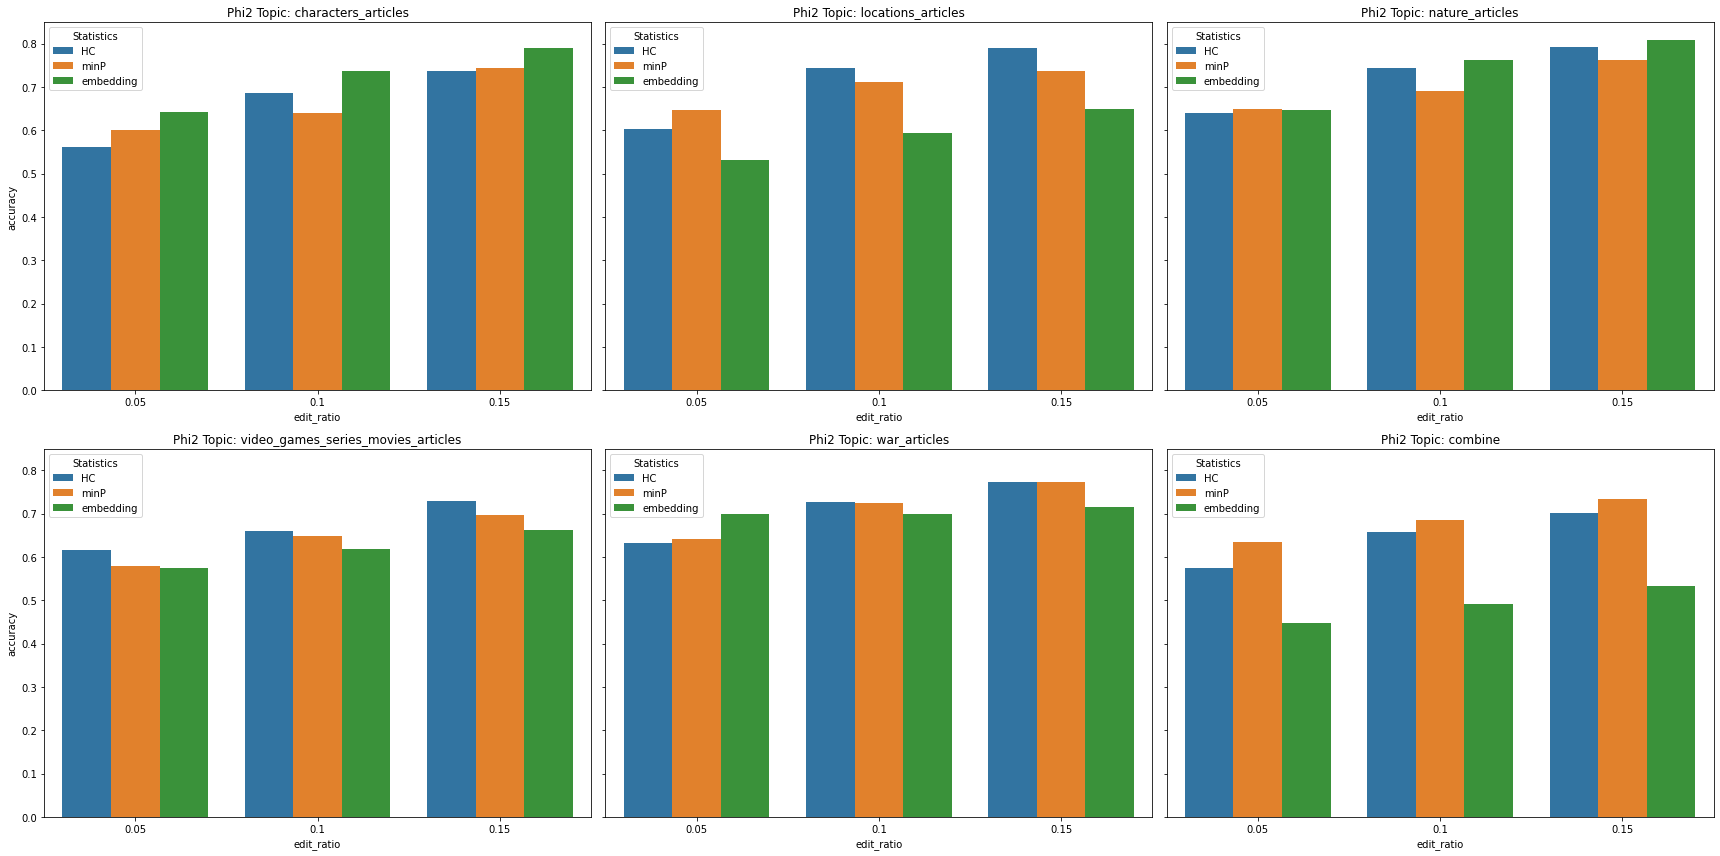

In [24]:
# Load the dataset
df = pd.read_csv("D:\\.Idan\\תואר שני\\תזה\\mainDataset_results_20240808.csv")
# List of topics
topics = df['topic'].unique()

# Calculate the number of rows needed
num_topics = len(topics)
num_cols = 3
num_rows = math.ceil(num_topics / num_cols)

# Set up the matplotlib figure with appropriate size
fig, axes = plt.subplots(num_rows, num_cols, figsize=(24, 6 * num_rows), sharey=True)

# Flatten the axes array for easy iteration if necessary
axes = axes.flatten()

# Plot each topic
for ax, topic in zip(axes, topics):
    topic_df = df[(df['topic'] == topic) & ((df['model'] == 'phi2') | (df['model'] == 'logistic_regression')) 
                  & (df['train/test ratio'] == '50-50')]
    sns.barplot(data=topic_df, x="edit_ratio", y="accuracy", hue="statistics", ax=ax)
    ax.set_title(f'Phi2 Topic: {topic}')
    ax.legend(title='Statistics')

# Adjust layout
plt.tight_layout()
plt.show()

In [4]:
# Clear folders
edit_ratios = [0.05, 0.1, 0.15] 
topics = ['characters_articles', 'locations_articles', 'nature_articles', 'video_games_series_movies_articles', 'war_articles'] 
files_path = 'D:\\.Idan\\תואר שני\\תזה\\mainDataset\\generatedArticles\\Cross_validation'

for topic in topics:
    for edit_ratio in edit_ratios:
        for fold in range(10):
            for folden_name in ['results', 'results_phi2']:
                folder_path = f'{files_path}\\{topic}\\edit_ratio_{edit_ratio}\\fold_{fold}\\{folden_name}'
                files = glob.glob(f'{folder_path}/*.csv')
                for file in files:
                    os.remove(file)

In [5]:
import pandas as pd
df = pd.read_csv('D:\\.Idan\\תואר שני\\תזה\\mainDataset\\generatedArticles\\Cross_validation\\combine\\edit_ratio_0.05\\combine_full.csv')
df = df.sample(frac=1, random_state=555)[:int(len(df) * 0.2)]
df.to_csv('D:\\.Idan\\תואר שני\\תזה\\mainDataset\\generatedArticles\\Cross_validation\\combine\\edit_ratio_0.05\\combine.csv', index=False)